  <a href="https://colab.research.google.com/github/ikitova/MLatImperial2022/lab02_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear classification for real task

We'll try to solve clients' churn task using data of mobile network operator.

We have to predict whether customer will change the mobile network operator.

The target field here is 'Churn'.

Let's transform raw data, then make a Logistic Regression model and adjust it's parameteres.

Upload data and have a look at it

In [4]:
!wget https://raw.githubusercontent.com/ikitova/MLatImperial2022/main/telecom_churn.csv

--2022-01-23 15:27:51--  https://raw.githubusercontent.com/ikitova/MLatImperial2022/main/telecom_churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279997 (273K) [text/plain]
Saving to: ‘telecom_churn.csv’

telecom_churn.csv   100%[===================>] 273.43K  --.-KB/s    in 0.03s   

2022-01-23 15:27:51 (8.91 MB/s) - ‘telecom_churn.csv’ saved [279997/279997]



In [5]:
from matplotlib.pylab import rc, plot
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

random_state=0
df = pd.read_csv('telecom_churn.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Transform target and  some other fields

In [6]:
d = {'Yes' : 1, 'No' : 0}
df['International plan'] = df['International plan'].map(d)
df['Voice mail plan'] = df['Voice mail plan'].map(d)
df['Churn'] = df['Churn'].astype('int64')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Divide data to design matrix X and target vector y.

Make a train-test split

In [7]:
#df=df.drop('State',axis=1)
df.head()
y=df['Churn']
X=df.drop('Churn',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,
                                                    random_state=0)

In [8]:
X.describe()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


We need to:
- Impute missing numeric and categorical values.

- Separate numerical and categorical fields.

- Scale numerical features

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)
X_train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
1460,MT,80,415,0,0,0,198.1,160,33.68,156.7,87,13.32,182.1,76,8.19,9.3,3,2.51,3
2000,PA,28,415,0,0,0,168.2,87,28.59,161.7,92,13.74,192.4,112,8.66,10.1,3,2.73,3
666,OR,120,415,0,0,0,252.0,120,42.84,150.2,106,12.77,151.8,96,6.83,9.6,1,2.59,2
2962,SD,105,415,0,0,0,251.6,88,42.77,175.1,103,14.88,184.4,112,8.30,5.4,5,1.46,1
2773,NJ,134,510,0,1,34,247.2,105,42.02,225.5,133,19.17,186.3,76,8.38,6.1,5,1.65,2


Now we don't extract all the information from the data, simply because we do not use some of the features. These features in the dataset are encoded in strings, each of them represents a certain category. 

Let's first fill in missing categorical features with special category "NotGiven". Sometimes the fact that a feature has a missing value can be a good sign itself.

In [13]:
numeric_features = numeric_data.columns
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [14]:
X_train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
1460,MT,80,415,0,0,0,198.1,160,33.68,156.7,87,13.32,182.1,76,8.19,9.3,3,2.51,3
2000,PA,28,415,0,0,0,168.2,87,28.59,161.7,92,13.74,192.4,112,8.66,10.1,3,2.73,3
666,OR,120,415,0,0,0,252.0,120,42.84,150.2,106,12.77,151.8,96,6.83,9.6,1,2.59,2
2962,SD,105,415,0,0,0,251.6,88,42.77,175.1,103,14.88,184.4,112,8.30,5.4,5,1.46,1
2773,NJ,134,510,0,1,34,247.2,105,42.02,225.5,133,19.17,186.3,76,8.38,6.1,5,1.65,2


### Categorical features encoding

Many ML algorithms do not work with categorial features and assume only numeric. If you want to transform categorial features into numeric, you may use encoding.  Two standard transformers from sklearn for working with categorical features are `OrdinalEncoder` (simply renumbers feature values with natural numbers) and `OneHotEncoder` (dummy features).

### One Hot Encoding

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

<img src="https://russianblogs.com/images/855/ddd65f4f342886bb411d41a33c5528e7.png" width=50%> 




A `OneHotEncoder` is a representation of categorical variables as binary vectors.

`OneHotEncoder` assigns to each feature a whole vector consisting of zeros and one unit (which stands in the place corresponding to the received value, thus encoding it).

Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

Is it worth to apply a scaling transformer to features encoded by `OneHotEncoder`?
What's about applying  `OrdinalEncoder` in the case of a linear model?

### Pipeline

We can write more streamlined  code with Pipeline:

<img src="https://miro.medium.com/max/620/1*ONryJuHGGUZ6PUmYTMiFxQ.png" width=50%>

Model training is often presented as a sequence of some actions with training and test sets (for example, you first need to scale the sample (and for the training set you need to apply the fit method, and for the test set - transform), and then train/apply the model (for the train sample fit, and make predictions for test sample)  

The `sklearn.pipeline.Pipeline` class allows you to store this sequence of steps and correctly applies it to both training and test samples.

sklearn also has a class to make a pipeline without naming: `sklearn.pipeline.make_pipeline` 


### ColumnTransformer
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

<img src="https://miro.medium.com/max/537/1*BNwN3cmbLLoU9CQoJgFSKQ.png" width=30%> 


We often need to apply different sets of tranformers to different groups of columns. For instance, we would want to apply OneHotEncoder to only categorical columns but not to numerical columns. This is where ColumnTransformer comes in. This time, we will partition the dataset keeping all columns so that we have both numerical and categorical features.

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore",sparse=False), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
X_train_encoded=column_transformer.fit_transform(X_train)

pd.DataFrame(X_train_encoded).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.510130,-0.526167,-0.320968,-0.615795,-0.589441,0.334535,2.962041,0.334802,-0.879648,-0.653460,-0.879573,-0.377791,-1.214353,-0.379791,-0.334364,-0.605667,-0.336336,1.097125
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.813562,-0.526167,-0.320968,-0.615795,-0.589441,-0.216885,-0.667438,-0.217378,-0.781652,-0.403801,-0.782731,-0.174258,0.602831,-0.173408,-0.049965,-0.605667,-0.046662,1.097125
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492510,-0.526167,-0.320968,-0.615795,-0.589441,1.328566,0.973285,1.328509,-1.007043,0.295246,-1.006391,-0.976535,-0.204806,-0.976985,-0.227714,-1.425524,-0.231000,0.338190
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116520,-0.526167,-0.320968,-0.615795,-0.589441,1.321189,-0.617719,1.320915,-0.519022,0.145451,-0.519873,-0.332342,0.602831,-0.331489,-1.720811,0.214190,-1.718868,-0.420745
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.843434,1.710152,-0.320968,1.623917,1.916153,1.240044,0.227502,1.239552,0.468778,1.643408,0.469303,-0.294797,-1.214353,-0.296360,-1.471962,0.214190,-1.468696,0.338190


### LogisticRegression

We've got 2 realizations of LogisticRegression:


https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

- class sklearn.linear_model.LogisticRegression ()
- class sklearn.linear_model.LogisticRegressionCV(*,

                     Cs=10, fit_intercept=True, cv=None, dual=False, penalty='l2',
                     
                     scoring=None,  solver='lbfgs', tol=0.0001, max_iter=100,
                     
                     class_weight=None, n_jobs=None, verbose=0, refit=True, 
                     
                     intercept_scaling=1.0, multi_class='auto', random_state=None, l1_ratios=None)
                     
   - Cs - Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
   - penalty -{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
   - solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’. Algorithm to use in the optimization problem. Default is ‘lbfgs’. 

   - cv : cvint or cross-validation generator, default=None
            The default cross-validation generator(for example,KFold or LeaveOneOut)  used is Stratified K-Folds. If an integer is provided, then it is the number of folds used. 
   - l1_ratioslist of float, default=None. The list of Elastic-Net mixing parameter
   
In addition to the standard `fit`,`predict` methods, the `predict_proba()` method is useful for classifiers  


Let's create a logistic regression with L2-regularization in Pipeline with feature transformation, find the best parameters on cross-validation on the grid of the regularization parameter С: [0.0001,0.001,0.01,0.1,1,10,100].
We'll use the LogisticRegressionCV and the number of cross-validation blocks cv=5

In [22]:
import warnings
warnings.simplefilter("ignore")

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegressionCV(penalty='l2',Cs=[0.0001,0.001,0.01,0.1,1,10,100],
                                        cv=5,refit=True))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_proba = model.predict_proba(X_test)
print(pd.DataFrame(y_proba[:, 1]).head())
#print(pd.DataFrame(y_proba).head())

          0
0  0.220462
1  0.085135
2  0.082727
3  0.043123
4  0.434491


In [23]:

from sklearn.metrics import accuracy_score
print("1. Test accuracy = %.4f" % accuracy_score(y_pred,y_test))
print("2. C = %.4f" % model['regression'].C_)


1. Test accuracy = 0.8771
2. C = 0.1000


In [24]:
#<YOUR TURN>
#try to use here GridSearchCV and LogisticRegression  instead of LogisticRegressionCV.
#did you get the same accuracy result?

#### Feature binarization


For feature binarization, you can use the class `sklearn.preprocessing.KBinsDiscretizer`:
sklearn.preprocessing.KBinsDiscretizer(n_bins=5, *, encode='onehot', strategy='quantile', dtype=None)

       strategy(default=’quantile’):
            - uniform - 
            - quantile -  
            - kmeans - 1D k-means cluster.
            - encode: 'ordinal'
Advantages of binarization: capturing non-monotonic and non-linear dependences feature from the target.
       


Instead of `StandardScaler`, we apply the class method `sklearn.preprocessing.KBinsDiscretizer` to numerical features with splitting into 25 groups and splitting strategy 'kmeans' to numerical features.
At the same time we apply `OneHotEncoder` to categorical features.
We use `ColumnTransformer` to combine uniformely these 2 transformation for the train and test datasets.



In [25]:
from sklearn.preprocessing import KBinsDiscretizer

In [26]:
%%time
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('binner',  KBinsDiscretizer(n_bins=25, strategy='quantile'), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression',  LogisticRegressionCV(penalty='l2',Cs=[0.0001,0.001,0.01,0.1,1,10,100],cv=5,
                                       random_state=random_state))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test accuracy = %.4f" % accuracy_score(y_pred,y_test))
print("C= %.4f" % model[1].C_)


Test accuracy = 0.8771
C= 0.1000
CPU times: user 1.38 s, sys: 3.9 ms, total: 1.38 s
Wall time: 1.38 s


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [27]:
#you turn 
#apply polinomial features instead of Kbindiskretizer and calculate accuracy
#compare time of running (use magic %%time)

In [29]:
%%time
import numpy as np
from sklearn.preprocessing import PolynomialFeatures



column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('binner',   PolynomialFeatures(2), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression',  LogisticRegressionCV(penalty='l1',Cs=[0.0001,0.001,0.01,0.1,1,10,100],cv=5,solver='saga',
                                       random_state=random_state))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test accuracy = %.4f" % accuracy_score(y_pred,y_test))
print("C= %.4f" % model[1].C_)

Test accuracy = 0.8876
C= 10.0000
CPU times: user 33 s, sys: 572 ms, total: 33.5 s
Wall time: 32.8 s


Visualization of quantile binaization of features

In [41]:

import seaborn as sns
import matplotlib.pyplot as plt
df['q_minutes'] = pd.qcut(df['Total intl minutes'], 11)
df['share'] = pd.qcut(df['Total day charge'],11,precision=2)
df.head(10)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,q_minutes,share
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,"(9.4, 10.0]","(42.99, 59.64]"
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,"(12.7, 13.8]","(27.18, 29.52]"
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,"(11.9, 12.7]","(38.89, 42.99]"
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,"(6.5, 7.8]","(42.99, 59.64]"
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,"(10.0, 10.6]","(27.18, 29.52]"
5,AL,118,510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0,"(-0.001, 6.5]","(36.25, 38.89]"
6,MA,121,510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,"(6.5, 7.8]","(36.25, 38.89]"
7,MO,147,415,1,0,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,0,"(6.5, 7.8]","(24.99, 27.18]"
8,LA,117,408,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,0,"(7.8, 8.7]","(29.52, 31.67]"
9,WV,141,415,1,1,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0,"(10.6, 11.2]","(42.99, 59.64]"


Text(0.5, 0, "'Total intl minutes'")

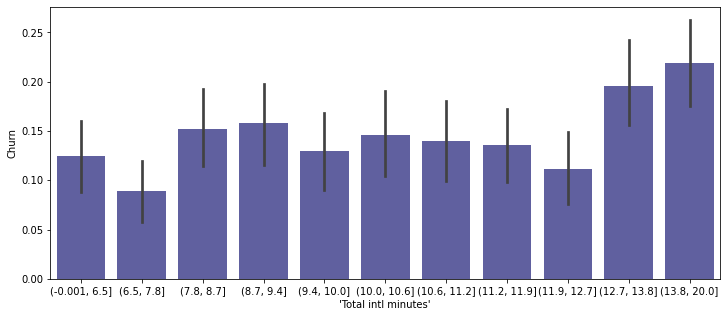

In [42]:

plt.figure(figsize=(12,5))
sns.barplot(x= 'q_minutes',y='Churn',data=df,color="blue",saturation=0.25)
plt.xlabel("'Total intl minutes'")



Text(0.5, 0, 'Total day charge')

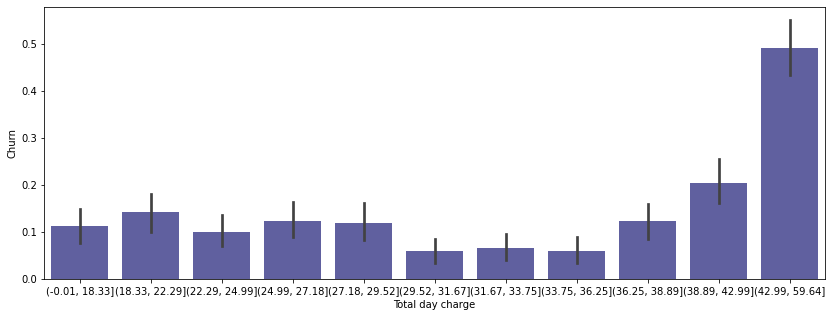

In [44]:
plt.figure(figsize=(14,5))
sns.barplot(x= 'share',y='Churn',data=df,color="blue",saturation=0.25)
plt.xlabel("Total day charge")


why polynomial features extracts more information from data than KBinsDiscretizer?

Is it worth to try polynomial featues of degree more than 2?